In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints

from matplotlib import animation, rc
from IPython.display import HTML, display
from pprint import pprint
import csv
import seaborn as sns
import pandas as pd
from sklearn import datasets
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [2]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [3]:
# pyro.set_rng_seed(1)
# pyro.enable_validation(True)

In [4]:
# dataset = datasets.load_iris()
dataset = datasets.load_wine()

x_data = torch.tensor(dataset.data.astype(np.float32)) # todo- normalize data
y_data = torch.tensor(dataset.target)

x_data[0], y_data[0]

(tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
         3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
         1.0650e+03]), tensor(0))

In [5]:
class Bayes(nn.Module):
    
    def __init__(self, num_classes, num_attributes, y_data):
        super(Bayes, self).__init__()
        self.apriori = self.get_y_proba(y_data)
        self.model = nn.Linear(num_attributes, num_classes)

        
    def forward(self, x):
        return self.model(x) * self.apriori
    
    def get_y_proba(self, y_data):
        y_unique = y_data.unique(sorted=True)
        y_unique_count = torch.stack([(y_data==y_u).sum() for y_u in y_unique]).float()
        return y_unique_count / len(y_data)
        return torch.tensor(y_unique_count, dtype=torch.float64).double() / len(y_data)
#         print(y_prob)
        

# bayes = Bayes(num_classes=3, num_attributes=4)
bayes = Bayes(num_classes=len(np.unique(y_data)), num_attributes=len(x_data[0]), y_data=y_data)
# bayes = Bayes(num_classes=4, num_attributes=4)

# bayes.model
# bayes.model(x_data[0])
bayes.forward(x_data[0])
# x_data[:2]
# torch.tensor([.5, .5, .5]) * torch.tensor([.5, .5, .5])
# y = torch.tensor([.5]).unique()
# y

tensor([-92.9085,  28.2044,  52.1662], grad_fn=<MulBackward0>)

In [6]:
def model(x_data, y_data):
    
    w_prior = Normal(loc=torch.zeros_like(bayes.model.weight), scale=torch.ones_like(bayes.model.weight))
    b_prior = Normal(loc=torch.zeros_like(bayes.model.bias), scale=torch.ones_like(bayes.model.bias))
    
    
    
    priors = {'weight': w_prior, 'bias': b_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", bayes, priors)


    lifted_reg_model = lifted_module()
    lhat = lifted_reg_model(x_data)
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [7]:

def guide(x_data, y_data):
    
    # Weight distribution priors
    w_mu = torch.randn_like(bayes.model.weight)
    w_sigma = torch.randn_like(bayes.model.weight)
    
    w_mu_param = pyro.param("w_mu", w_mu)
    w_sigma_param = pyro.param("w_sigma", w_sigma, constraint=constraints.positive)
    w_prior = Normal(loc=w_mu_param, scale=w_sigma_param)
    
    # Bias distribution priors
    b_mu = torch.randn_like(bayes.model.bias)
    b_sigma = torch.randn_like(bayes.model.bias)
    b_mu_param = pyro.param("b_mu", b_mu)
    b_sigma_param = pyro.param("b_sigma", b_sigma,  constraint=constraints.positive)
    b_prior = Normal(loc=b_mu_param, scale=b_sigma_param)

   
    priors = {'weight': w_prior, 'bias': b_prior}
    
  
    lifted_module = pyro.random_module("module", bayes, priors)
    
    return lifted_module()

In [8]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [9]:
y_data[80]

tensor(1)

In [10]:
def train(num_iterations=500, lr=0.01, guide_function=None):
    pyro.clear_param_store()
#     model = create_probabilistic_model()
    
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=len(x_data))
    t=tqdm(range(num_iterations))
    
    losses = []
    for j in t:
        loss = svi.step(x_data, y_data)
        losses.append(loss)
        t.set_postfix(loss=loss)
    return (model, svi, losses)

model, svi, losses = train()

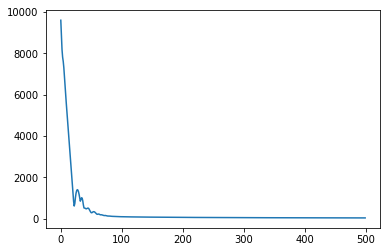

In [11]:
plt.plot(losses)

In [12]:
num_samples = 1
y_true = y_data
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
#     return [y for y in yhats]
    return [np.argmax(y, axis=1) for y in yhats]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)
predicted= predict(x_data)[0]

In [13]:
predicted

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
from sklearn import metrics as m

In [15]:
pd.DataFrame(m.confusion_matrix(y_data, predicted))

,0,1,2
0,55,4,0
1,2,68,1
2,0,1,47


In [16]:
m.accuracy_score(y_true, predicted)

0.9550561797752809

In [17]:
m.f1_score(y_true, predicted, average='macro')

0.95729565772669212

In [18]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(x_data, y_data)

GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
sklearn_pred = nb_clf.predict(x_data)
pd.DataFrame(m.confusion_matrix(y_data, sklearn_pred))

,0,1,2
0,58,1,0
1,0,70,1
2,0,0,48


In [20]:
m.accuracy_score(y_true, sklearn_pred)

0.9887640449438202

In [21]:
m.f1_score(y_true, sklearn_pred, average='macro')

0.98901973535340748